In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:

Path.cwd()

PosixPath('/Users/sonya0706/Documents/CSI/payload-2025-26/model')

In [3]:
# Reading simulated data from sim

BASE_DIR = Path.cwd()  # model/
sim_dir = BASE_DIR.parent / "sim" / "flights"

dfs = []

for i, csv_file in enumerate(sim_dir.glob("*.csv")):
    d = pd.read_csv(csv_file)
    d["flight_id"] = i  # keep track of which flight
    dfs.append(d)

df = pd.concat(dfs, ignore_index=True)

In [4]:
df.head()

,# Time (s),acceleration Magnitude (m/s²),Vz (m/s),Z (m),flight_id
0,0.00000,71.197573,0.000000,697.000000,0
1,0.00576,71.205985,0.409156,697.002357,0
2,0.01152,71.214358,0.818361,697.007070,0
3,0.02152,71.228799,1.528858,697.018807,0
4,0.03152,71.243087,2.239499,697.037648,0


In [5]:
# Rename columns
df = df.rename(columns = {"# Time (s)":"time", " acceleration Magnitude (m/s²)":"acceleration", " Vz (m/s)":"vz", " Z (m)":"z"})

In [6]:
# set index time 
df = df.sort_values("time").reset_index(drop=True)
df

,time,acceleration,vz,z,flight_id
0,0.000000,71.197573,0.000000,697.000000,0
1,0.000000,71.205390,0.000000,697.000000,21
2,0.000000,71.182846,0.000000,697.000000,22
3,0.000000,71.221574,0.000000,697.000000,23
4,0.000000,71.179551,0.000000,697.000000,24
...,...,...,...,...,...
1292536,362.505445,0.259481,-5.423390,697.150029,32
1292537,362.508148,0.400788,-5.405881,697.000000,10
1292538,362.515445,0.259479,-5.423354,697.095796,32
1292539,362.525445,0.257455,-5.423319,697.041562,32


In [7]:
# normalize features
features = ["acceleration", "vz", "z"]
X_raw = df[features].to_numpy()   # (T, 3)

mu = X_raw.mean(axis=0, keepdims=True)
sigma = X_raw.std(axis=0, keepdims=True) + 1e-8

X_norm = (X_raw - mu) / sigma

In [8]:
df[features] = X_norm

In [9]:
df[features].describe()

,acceleration,vz,z
count,1.292541e+06,1.292541e+06,1.292541e+06
mean,2.247278e-16,1.190046e-16,8.781535e-16
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.470889e-01,-4.005213e-01,-1.240076e+00
25%,-1.426008e-01,-3.669776e-01,-9.023752e-01
50%,-1.389700e-01,-3.411982e-01,-2.530644e-01
75%,-1.325935e-01,-1.097687e-01,8.744688e-01
max,8.479035e+02,6.450570e+00,1.981823e+00


In [10]:
assert not df[features].isna().any().any()
assert np.isfinite(df[features].to_numpy()).all()

Makeing Sliding Windows

In [11]:
def make_windows(X, window_len=52, stride=13):
    windows = []
    for start in range(0, len(X) - window_len + 1, stride):
        windows.append(X[start:start + window_len])
    return np.stack(windows)

all_windows = []

for flight_id in df["flight_id"].unique():
    flight_df = df[df["flight_id"] == flight_id]

    X_flight = flight_df[["acceleration", "vz", "z"]].values  
    
    windows = make_windows(X_flight, 52, 13)
    all_windows.append(windows)

X_win = np.concatenate(all_windows, axis=0)

In [12]:
print(X_win.shape)

(99301, 52, 3)


Testing Out Model 

In [13]:
# Read model from .py file
from cnn1d import CAE1D

2026-02-19 17:25:39.855102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model = CAE1D(window_length=52)
ae = model.build_cnn1d_autoencoder()
ae.summary()

Model: "1DCAE_unsupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 52, 3)]           0         
                                                                 
 encoder_1dcae (Functional)  (None, 13, 32)            3344      
                                                                 
 decoder_1dcae (Functional)  (None, None, 3)           4803      
                                                                 
Total params: 8,147
Trainable params: 8,147
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Training model 
history = ae.fit(
    X_win,
    X_win,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.1
)

Epoch 1/50
2793/2793 [==============================] - 5s 2ms/step - loss: 0.4051 - val_loss: 0.5189
Epoch 2/50
2793/2793 [==============================] - 5s 2ms/step - loss: 0.8324 - val_loss: 0.5184
Epoch 3/50
2793/2793 [==============================] - 5s 2ms/step - loss: 0.8322 - val_loss: 0.5184
Epoch 4/50
2793/2793 [==============================] - 5s 2ms/step - loss: 0.8322 - val_loss: 0.5184
Epoch 5/50
2793/2793 [==============================] - 5s 2ms/step - loss: 0.8322 - val_loss: 0.5184
Epoch 6/50
2793/2793 [==============================] - 5s 2ms/step - loss: 0.8322 - val_loss: 0.5184
Epoch 7/50
2793/2793 [==============================] - 5s 2ms/step - loss: 0.8321 - val_loss: 0.5183
Epoch 8/50
2793/2793 [==============================] - 5s 2ms/step - loss: 0.8321 - val_loss: 0.5184
Epoch 9/50
2793/2793 [==============================] - 5s 2ms/step - loss: 0.8321 - val_loss: 0.5186
Epoch 10/50
2793/2793 [==============================] - 5s 2ms/step - loss: 0.832

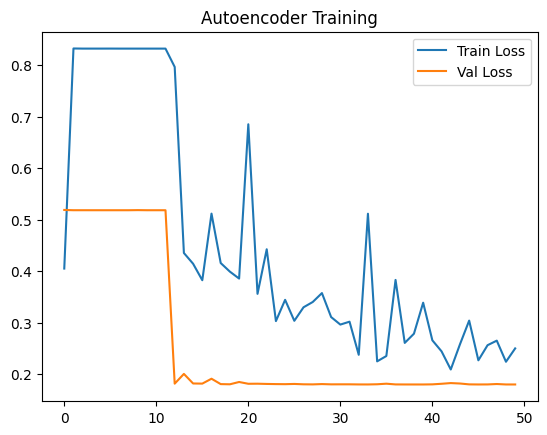

In [19]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Autoencoder Training")
plt.show()

In [18]:
# Reconstruction and anomaly score
X_hat = ae.predict(X_win)
recon_error = np.mean((X_win - X_hat)**2, axis=(1, 2))

3104/3104 [==============================] - 2s 654us/step


In [25]:
len(recon_error)

99301

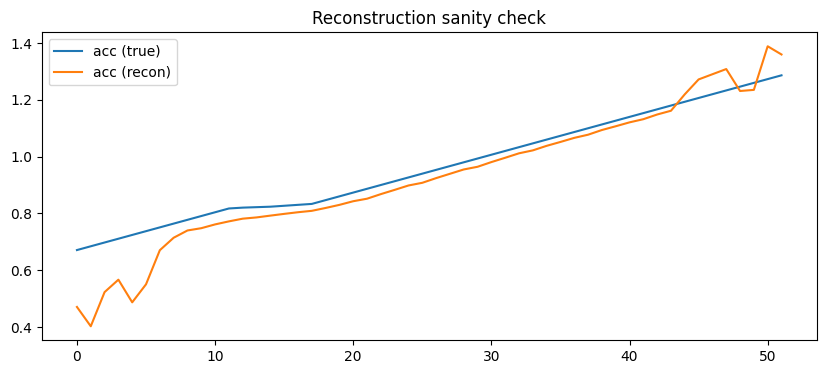

In [49]:
# window number 

i = 4

plt.figure(figsize=(10, 4))
plt.plot(X_win[i, :, 1], label="acc (true)")
plt.plot(X_hat[i, :, 1], label="acc (recon)")
plt.legend()
plt.title("Reconstruction sanity check")
plt.show()

In [22]:
threshold = np.percentile(recon_error, 95)

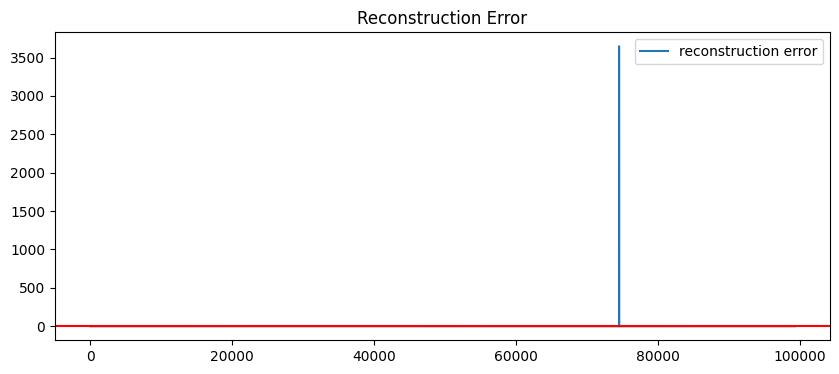

In [23]:


plt.figure(figsize=(10, 4))
plt.plot(recon_error, label="reconstruction error")
plt.axhline(threshold, color='r')
plt.legend()
plt.title("Reconstruction Error")
plt.show()

In [35]:
print("Max error:", np.max(recon_error))
print("Index of max:", np.argmax(recon_error))

Max error: 3646.1541499869154
Index of max: 74556


In [40]:
np.sum(recon_error > 3000)

2

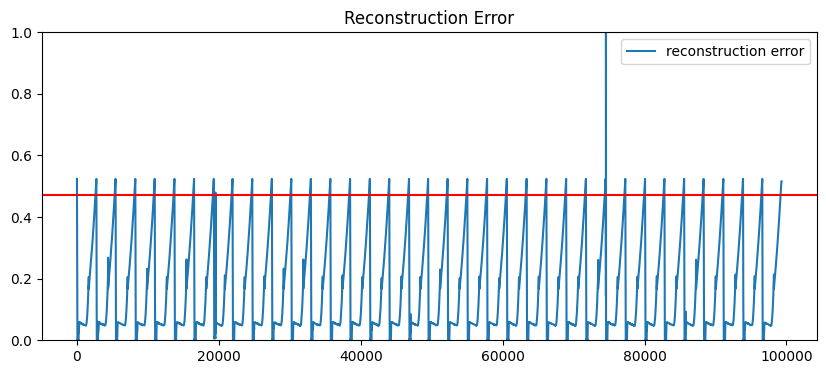

In [47]:

plt.figure(figsize=(10, 4))
plt.plot(recon_error, label="reconstruction error")
plt.ylim(0, 1) 
plt.axhline(threshold, color='r')
plt.legend()
plt.title("Reconstruction Error")
plt.show()

(array([9.9297e+04, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([4.35255351e-04, 7.29235095e+01, 1.45846584e+02, 2.18769658e+02,
        2.91692732e+02, 3.64615807e+02, 4.37538881e+02, 5.10461955e+02,
        5.83385030e+02, 6.56308104e+02, 7.29231178e+02, 8.02154252e+02,
        8.75077327e+02, 9.48000401e+02, 1.02092348e+03, 1.09384655e+03,
        1.16676962e+03, 1.2396

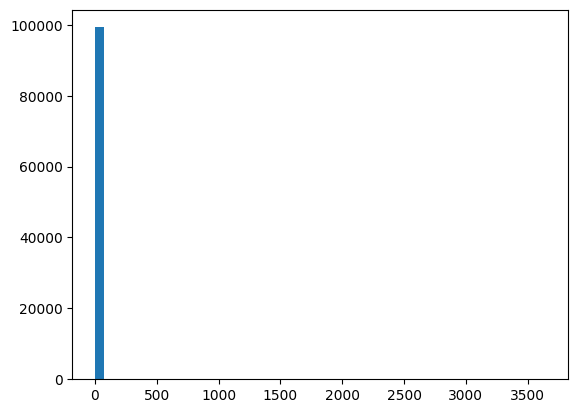

In [24]:
plt.hist(recon_error, bins=50)